In [26]:
#Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

## Generate Data

In [3]:
# read csv
train_data = pd.read_csv('data/train.csv')
train_data

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [65]:
Date = train_data['Date']
Sales = train_data['Weekly_Sales']

In [4]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Date']

0        2010-02-05
1        2010-02-12
2        2010-02-19
3        2010-02-26
4        2010-03-05
            ...    
421565   2012-09-28
421566   2012-10-05
421567   2012-10-12
421568   2012-10-19
421569   2012-10-26
Name: Date, Length: 421570, dtype: datetime64[ns]

In [67]:
np.sum(train_data.isna())

C:\Users\romouya\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [68]:
train_data['Date'].value_counts()

Date
2011-12-23    3027
2011-11-25    3021
2011-12-16    3013
2011-12-09    3010
2012-02-17    3007
              ... 
2010-07-09    2903
2010-07-16    2901
2010-08-20    2901
2010-08-27    2898
2010-08-13    2896
Name: count, Length: 143, dtype: int64

In [69]:
train_data.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

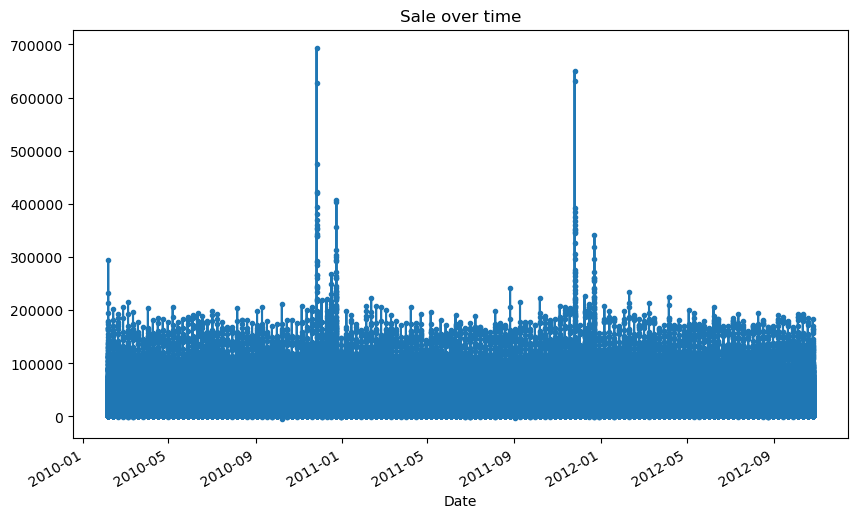

In [70]:
#plot the data
train_data
train_data.set_index('Date', inplace = True)
train_data['Weekly_Sales'].plot(style='.-', figsize=(10,6), title='Sale over time')
'''
plt.figure(figsize=(60,36))
plt.plot(Date, Sales)
plt.xlabel('Date')
plt.ylabel('Sales')
'''
plt.show()

### Add missing values in the train data set

In [31]:
# Create a complete date range from the minimum to the maximum date in the data
min_date = train_data['Date'].min()
max_date = train_data['Date'].max()
complete_date_range = pd.date_range(start=min_date, end=max_date, freq='W-FRI')


# Initialize an empty list to hold the dataframes
complete_dataframes = []

# Get unique combinations of Store and Dept
unique_store_dept = train_data[['Store', 'Dept']].drop_duplicates()

# Iterate over each unique store and department combination
for _, row in unique_store_dept.iterrows():
    store = row['Store']
    dept = row['Dept']
    
    # Filter data for the current store and department
    store_dept_data = train_data[(train_data['Store'] == store) & (train_data['Dept'] == dept)]
    
    # Create a dataframe with the complete date range for the current store and department
    complete_dates = pd.DataFrame({'Date': complete_date_range})
    complete_dates['Store'] = store
    complete_dates['Dept'] = dept
    
    # Merge the original data with the complete date range
    merged_data = pd.merge(complete_dates, store_dept_data, on=['Store', 'Dept', 'Date'], how='left')
    
    # Append the result to the list
    complete_dataframes.append(merged_data)

# Concatenate all dataframes in the list
final_data = pd.concat(complete_dataframes)

# Sort the data for better readability
final_data = final_data.sort_values(by=['Store', 'Dept', 'Date'])

final_data

,Date,Store,Dept,Weekly_Sales,IsHoliday
0,2010-02-05,1,1,24924.50,False
1,2010-02-12,1,1,46039.49,True
2,2010-02-19,1,1,41595.55,False
3,2010-02-26,1,1,19403.54,False
4,2010-03-05,1,1,21827.90,False
...,...,...,...,...,...
138,2012-09-28,45,98,508.37,False
139,2012-10-05,45,98,628.10,False
140,2012-10-12,45,98,1061.02,False
141,2012-10-19,45,98,760.01,False


In [85]:
np.sum(final_data.isna())

C:\Users\romouya\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Date                0
Store               0
Dept                0
Weekly_Sales    54763
IsHoliday       54763
dtype: int64

## Missing Value

In [49]:
#using Department 98 of Store 45 as an example
data_45_98 = final_data[(final_data['Store'] == 45) & (final_data['Dept'] == 98)] 
data_45_98.dtypes

Date            datetime64[ns]
Store                    int64
Dept                     int64
Weekly_Sales           float64
IsHoliday               object
dtype: object

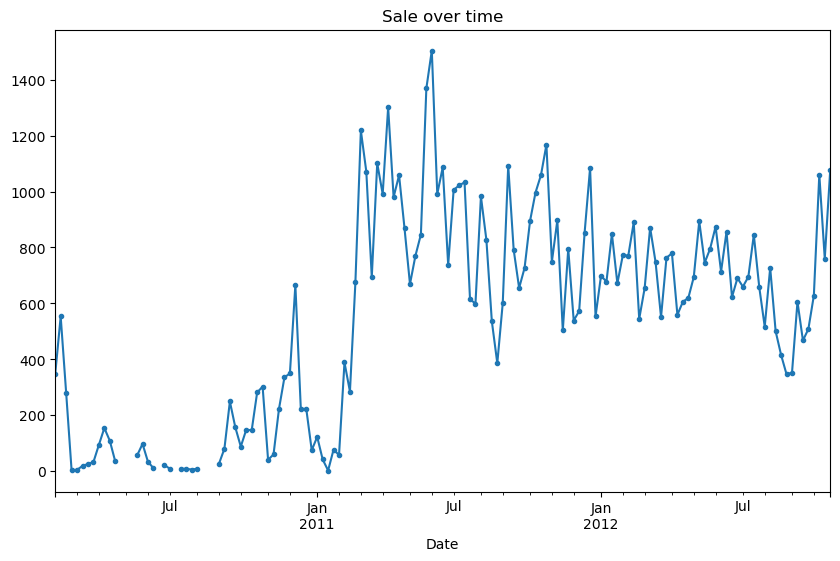

In [50]:
data_45_98.set_index('Date', inplace = True)
data_45_98['Weekly_Sales'].plot(style='.-', figsize=(10,6), title='Sale over time')

plt.show()

### Seasonal Trend Decomposition using Loess (STL)

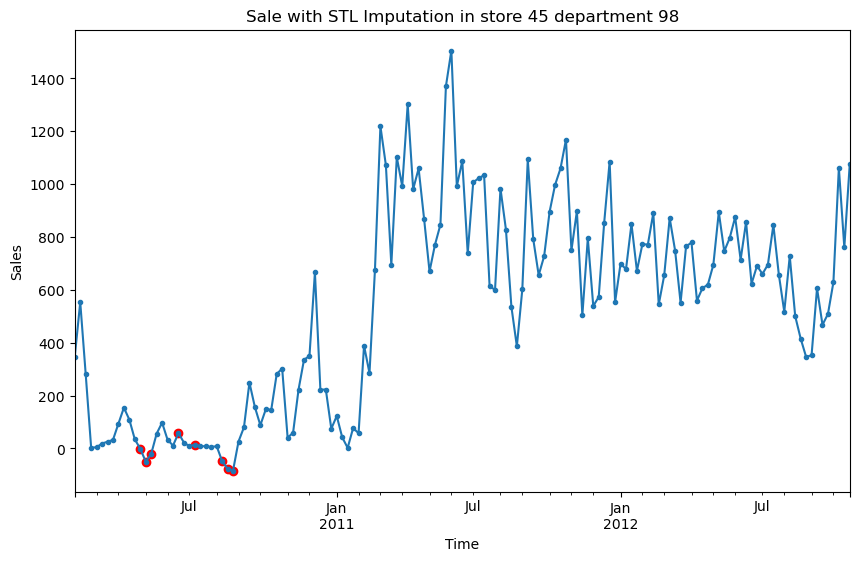

In [59]:
# Make a copy of data of Department 98 of Store 45
df_4598_stl = data_45_98.copy()

#Fill missing values in the time series
imputed_indices = data_45_98[data_45_98['Weekly_Sales'].isnull()].index

#Apply STL decomposition
stl = STL(df_4598_stl['Weekly_Sales'].interpolate(), seasonal=11)
res = stl.fit()

#Extract the seasonal and trend components
seasonal_component = res.seasonal

#Deseasonalised series
df_4598_deseasonlised = df_4598_stl['Weekly_Sales'] - seasonal_component

#Interpolate missing values in the deseasonalised series
df_4598_deseasonlised_imputed = df_4598_deseasonlised.interpolate(method='linear')

#Add the seasonal component back 
df_4598_imputed = df_4598_deseasonlised_imputed + seasonal_component

#Update the original dataframe with the imputed values
df_4598_stl.loc[imputed_indices,'Weekly_Sales'] = df_4598_imputed[imputed_indices]

#Plot the series
plt.figure(figsize = [10,6])
df_4598_stl['Weekly_Sales'].plot(style='.-', figsize=(10,6), title='Sale with STL Imputation in store 45 department 98')
plt.scatter(imputed_indices, df_4598_stl.loc[imputed_indices,'Weekly_Sales'], color = 'red')
plt.ylabel('Sales')
plt.xlabel('Time')
plt.show()

## Detect Outliers (using store 45 department 98)

### Box plots

C:\Users\romouya\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


<Axes: >

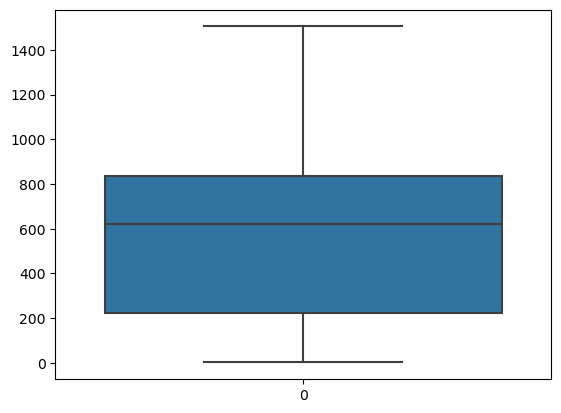

In [56]:
df_4598 = data_45_98.copy()
sns.boxplot(df_4598['Weekly_Sales'])

### Inter-Quartile Range

C:\Users\romouya\AppData\Local\Temp\ipykernel_22848\3744359293.py:4: RuntimeWarning: invalid value encountered in greater
  outliers = df_4598[(df_4598.values > np.quantile(df_4598['Weekly_Sales'],0.75) + 1.5* IQR)| (df_4598.values < np.quantile(df_4598['Weekly_Sales'],0.25) - 1.5* IQR)].values
C:\Users\romouya\AppData\Local\Temp\ipykernel_22848\3744359293.py:4: RuntimeWarning: invalid value encountered in less
  outliers = df_4598[(df_4598.values > np.quantile(df_4598['Weekly_Sales'],0.75) + 1.5* IQR)| (df_4598.values < np.quantile(df_4598['Weekly_Sales'],0.25) - 1.5* IQR)].values
C:\Users\romouya\AppData\Local\Temp\ipykernel_22848\3744359293.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_4598_new = df_4598_nans.interpolate(method='linear', axis=0).ffill().bfill()


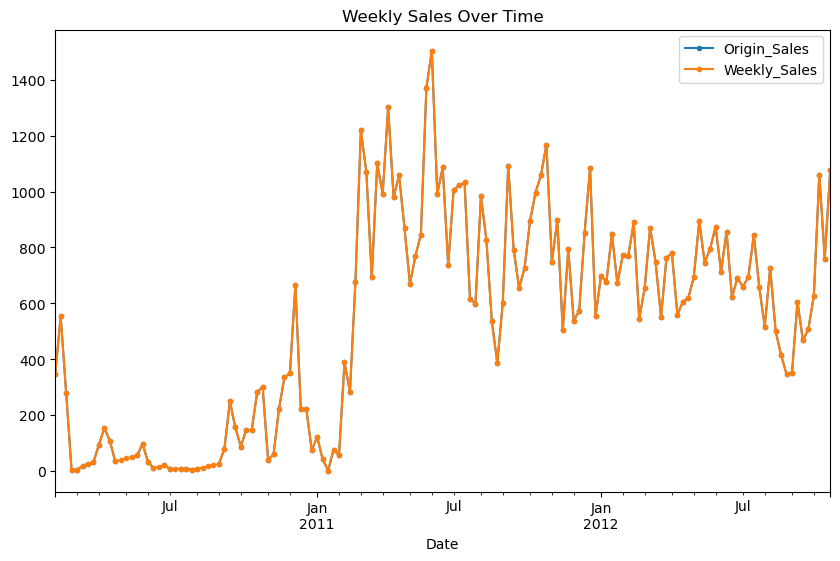

In [55]:
from numpy import NaN
df_4598 = data_45_98.copy()
IQR = np.quantile(df_4598['Weekly_Sales'],0.75) - np.quantile(df_4598['Weekly_Sales'],0.25)
outliers = df_4598[(df_4598.values > np.quantile(df_4598['Weekly_Sales'],0.75) + 1.5* IQR)| (df_4598.values < np.quantile(df_4598['Weekly_Sales'],0.25) - 1.5* IQR)].values
df_4598_nans = df_4598.replace(outliers, NaN)
df_4598_new = df_4598_nans.interpolate(method='linear', axis=0).ffill().bfill()
df_4598_new['Origin_Sales'] = df_4598['Weekly_Sales']

#plot the data
df_4598_new[['Origin_Sales','Weekly_Sales']].plot(style='.-', figsize = (10,6),title = 'Weekly Sales Over Time')
plt.show()

#### Conclusion: No outliers are found in store 45 department 98

### Decomposition

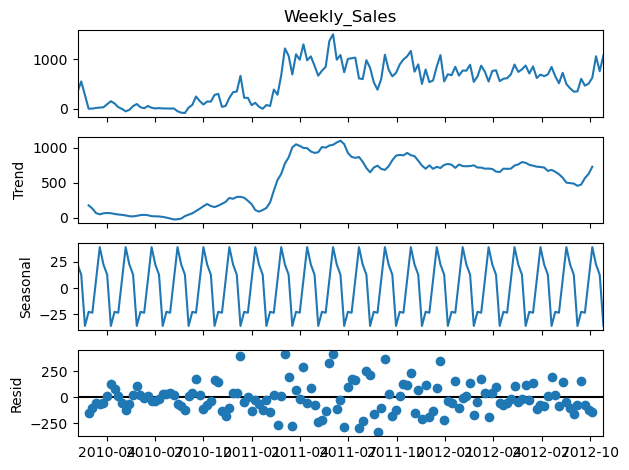

In [61]:
result = seasonal_decompose(df_4598_stl['Weekly_Sales'], model ='additive', period = 7)
result.plot()
plt.show()